# Example-Create-Population-West-London

This notebook demonstrates an example workflow for creating a sample population automatically for the west London area. It creates test agent plans of person and households. 

### Aim: 
Create a bigger and more realistic sample population automatically for the west london area called Londinium. The sample population includes various activities, personal attributes and modes and the population would be used as input for MATSim transport simulation.

- Import geographic data of Londinium.
- Activity generation model with home based tours. Expand agents with different personal attributes, activities and trips.
- Perform Data Visualization and validation. Plot the activity plan, distance and duration of population
- Export intermediate CSV tables of the population

In [1]:
import os
import numpy as np
from random import choice
import pandas as pd
import geopandas as gp
from matplotlib import pyplot as plt
from shapely.geometry import Point

from pam.core import Population, Household, Person
from pam.activity import Plan, Activity, Leg
from pam.utils import minutes_to_datetime as mtdt
from pam.variables import END_OF_DAY
from pam.write import write_matsim, write_od_matrices, write_duration_benchmark, write_distance_benchmark, to_csv
from pam.plot.stats import plot_activity_times, plot_leg_times
from pam.read import load_travel_diary, read_matsim
from pam.write import write_matsim

## Import geographic data of Londinium

In [2]:
# Import geographic data of west london area
network_bb_path = os.path.join("data", "network_bounding_box.geojson")
lsoas_path = os.path.join("data", "lsoas") # lsoas: lower layer super output areas 

epsg:4326
epsg:27700


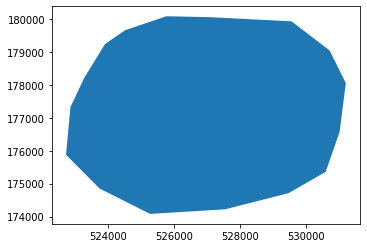

In [3]:
# read the file and plot the boundary
boundary = gp.read_file(network_bb_path)
print(boundary.crs)

# Use same spatial coordinate system
boundary = boundary.to_crs("epsg:27700") # Transform to epsg:27700
print(boundary.crs)
boundary.plot()

EPSG:27700 Projected coordinate system for United Kingdom (UK). EPSG 4326 is just the EPSG identifier of WGS84.

epsg:27700


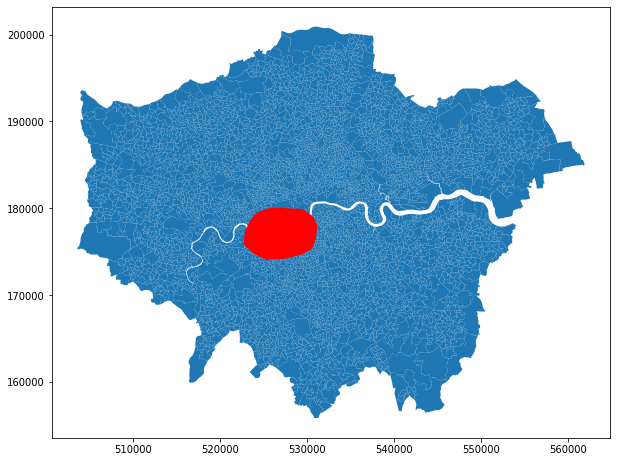

In [4]:
# Plot boundary area in lsoas
lsoas = gp.read_file(lsoas_path)
print(lsoas.crs)
lsoas = lsoas.set_index("LSOA_CODE")

fig, ax = plt.subplots(figsize=(10,10))
lsoas.plot(ax = ax)
boundary.plot(ax = ax, color='red')       

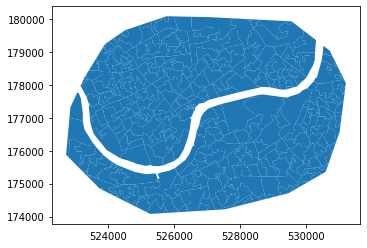

In [5]:
# Overlay the area using geopandas package
lsoas_clipped = gp.overlay(lsoas, boundary, how='intersection')
lsoas_clipped.plot()

In [6]:
lsoas_clipped.head()

LSOA_NAME  MSOA_CODE                   MSOA_NAME  \
0  Hammersmith and Fulham 010A  E02000381  Hammersmith and Fulham 010   
1  Hammersmith and Fulham 010B  E02000381  Hammersmith and Fulham 010   
2  Hammersmith and Fulham 012A  E02000383  Hammersmith and Fulham 012   
3  Hammersmith and Fulham 012B  E02000383  Hammersmith and Fulham 012   
4  Hammersmith and Fulham 012C  E02000383  Hammersmith and Fulham 012   

  STWARDCODE                STWARDNAME LA_CODE                 LA_NAME  \
0     00ANGA                   Addison    00AN  Hammersmith and Fulham   
1     00ANGA                   Addison    00AN  Hammersmith and Fulham   
2     00ANGC  Avonmore and Brook Green    00AN  Hammersmith and Fulham   
3     00ANGC  Avonmore and Brook Green    00AN  Hammersmith and Fulham   
4     00ANGC  Avonmore and Brook Green    00AN  Hammersmith and Fulham   

                                            geometry  
0  POLYGON ((523936.254 179252.052, 523932.247 17...  
1  POLYGON ((524142.510 179393.859, 524171.272 17...  
2  POLYGON ((524191.002 178908.997, 524167.660 17...  
3  POLYGON ((523709.779 178708.514, 523774.000 17...  
4  MULTIPOLYGON (((524412.934 178788.791, 524422....

In [7]:
lsoas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 4765 entries, E01000001 to E01004765
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   LSOA_NAME   4765 non-null   object  
 1   MSOA_CODE   4765 non-null   object  
 2   MSOA_NAME   4765 non-null   object  
 3   STWARDCODE  4765 non-null   object  
 4   STWARDNAME  4765 non-null   object  
 5   LA_CODE     4765 non-null   object  
 6   LA_NAME     4765 non-null   object  
 7   geometry    4765 non-null   geometry
dtypes: geometry(1), object(7)
memory usage: 464.1+ KB


## Activity geneartion model

In [8]:
# Create random area sample
def random_area_sampler():
    indexes = list(lsoas_clipped.index)
    return np.random.choice(indexes)

random_area_sampler()  # test

224

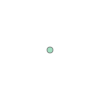

In [9]:
# Use pam install package to create random point
from pam.samplers.spatial import RandomPointSampler

point_sampler = RandomPointSampler(geoms=lsoas_clipped)

point_sampler.sample(idx=random_area_sampler(), activity=None) # test

- It is a simple home based tours within 24 hours. 
- we create different activity types: work, leisure, education, shopping, etc. Different transport model types: car, bus, subway, etc. 
- Random number is assigned to the duration for each activity and transport mode

In [10]:
# Generate agents in west london area
def generate_agents(no_of_agents):
    """
    Randomly create agents with simple home based tours. The trip started from home, 
    random number of various acitivites, tranport modes would be added. The trip finally end at home.
    """
    
    population = Population() # Initialise an empty population
    
    # Create simple personal attributes
    income = ["low", "medium", "high"]
    gender = ["male", "female"]
    
    # Create mode and activities
    transport= ['car', 'bus', 'ferry', 'rail', 'subway', 'bike', 'walk']
    activity = ["work", "leisure", "education", "shop", "shop_food", "gym", "park", "pub"] # Primary activity
    sub_activity = ["shop", "shop_food", "gym", "park", "pub"] # People usually spend less time on sub activity

    
    # Add activity plan for each person
    for i in range(no_of_agents):

        # Create different agents and household
        agent_id = f"agent_{i}"
        hh_id = f"hh_{i}"
        hh = Household(hh_id, freq=1)
        agent = Person(agent_id, freq = 1, attributes= {"subpopulation": np.random.choice(income) + " income",
                                                 "gender" : np.random.choice(gender),
                                                 "age": np.random.randint(10,70)
                                                })
        
        hh.add(agent)
        population.add(hh)
        
        # Trip duration
        trip_duration_main_activity = (np.random.randint(3, 6) * 60) 
        trip_duration_sub_activity = (np.random.randint(1, 3) * 60)
        
        # Adding Activities and Legs alternately to different agents
        # Activity 1 - home
        leaves_home = (np.random.randint(6, 8) * 60) + np.random.randint(0, 100)  # minutes
        location1 = random_area_sampler()
        location1_loc = point_sampler.sample(idx = location1, activity = None)
   
        agent.add(Activity(
            seq = 1,
            act ='home',
            area = location1,
            loc = location1_loc,
            start_time = mtdt(0),
            end_time = mtdt(leaves_home)
        ))
    
    
        # Initiated parameters
        location_prev = location1
        location_prev_loc = location1_loc
        leave_time = leaves_home
        
    
        # Add random numbers of activities
        no_of_activities = np.random.randint(1,5)
        for i in range(no_of_activities):
            
            # Outbound leg
            arrives_primary = leave_time + np.random.randint(10, 90)  # minutes
            location_next = random_area_sampler()
            location_next_loc = point_sampler.sample(idx=location_next, activity=None)
            
            # Activity 2.  
            if i < 2: # Start with main activity
                random_act = np.random.choice(activity)
            else: 
                random_act = np.random.choice(sub_activity)
                
            if random_act == ("work" or "education" or "leisure"):
                leaves_primary = arrives_primary + trip_duration_main_activity
            else:
                leaves_primary = arrives_primary + trip_duration_sub_activity
     
            agent.add(Leg(
                seq = i + 1,
                mode = np.random.choice(transport),
                start_area = location_prev,
                start_loc = location_prev_loc,
                end_area = location_next,
                end_loc = location_next_loc,
                start_time = mtdt(leave_time),
                end_time = mtdt(arrives_primary), 
            ))
    
            agent.add(Activity(
                seq = i + 2,
                act = random_act,
                area = location_next,
                loc = location_next_loc,
                start_time = mtdt(arrives_primary),
                end_time = mtdt(leaves_primary)
            ))     
        
            # Update parameters
            leave_time = leaves_primary
            location_prev = location_next
            location_prev_loc = location_next_loc
            
        
        # Inbound leg
        arrives_home = leave_time + np.random.randint(10,90)  # minutes
        agent.add(Leg(
                seq = no_of_activities + 1,
                mode = np.random.choice(transport),
                start_area = location_next,
                start_loc = location_next_loc,
                end_area = location1,
                end_loc = location1_loc,
                start_time = mtdt(leave_time),
                end_time = mtdt(arrives_home), 
            ))

        # Activity
        agent.add(Activity(
                seq = no_of_activities + 2,
                act ='home',
                area = location1,
                loc = location1_loc,
                start_time = mtdt(arrives_home),
                end_time = END_OF_DAY
            ))

    return population

In [11]:
# Create 100 agents and check the population statistics
population = generate_agents(100)
print(population.stats)

{'num_households': 100, 'num_people': 100, 'num_activities': 451, 'num_legs': 351}


## Data Visulazation and validation

In [12]:
# Validation if it works
population.validate()

In [13]:
# Print random person activity plan
population.random_person().print()

Person: agent_37
{'subpopulation': 'low income', 'gender': 'male', 'age': 36}
0:	Activity(1 act:home, location:POINT (530011.478204587 176492.3235540833), time:00:00:00 --> 07:22:00, duration:7:22:00)
1:	Leg(1 mode:subway, area:POINT (530011.478204587 176492.3235540833) --> POINT (528373.4829462538 175734.1199083086), time:07:22:00 --> 07:38:00, duration:0:16:00)
2:	Activity(2 act:shop_food, location:POINT (528373.4829462538 175734.1199083086), time:07:38:00 --> 09:38:00, duration:2:00:00)
3:	Leg(2 mode:ferry, area:POINT (528373.4829462538 175734.1199083086) --> POINT (530011.478204587 176492.3235540833), time:09:38:00 --> 11:04:00, duration:1:26:00)
4:	Activity(3 act:home, location:POINT (530011.478204587 176492.3235540833), time:11:04:00 --> 00:00:00, duration:12:56:00)


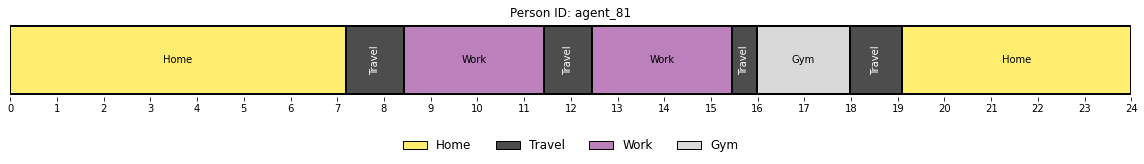

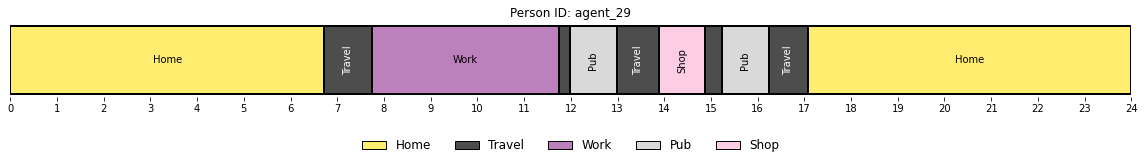

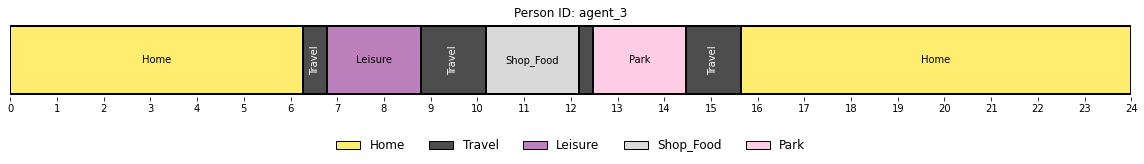

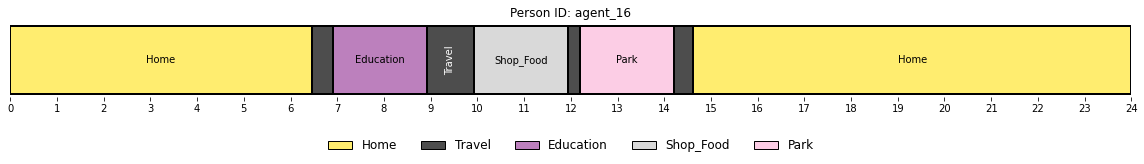

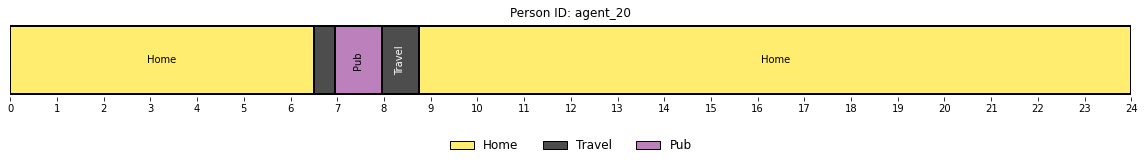

In [14]:
for i in range(5):
    p = population.random_person()
    p.plot()

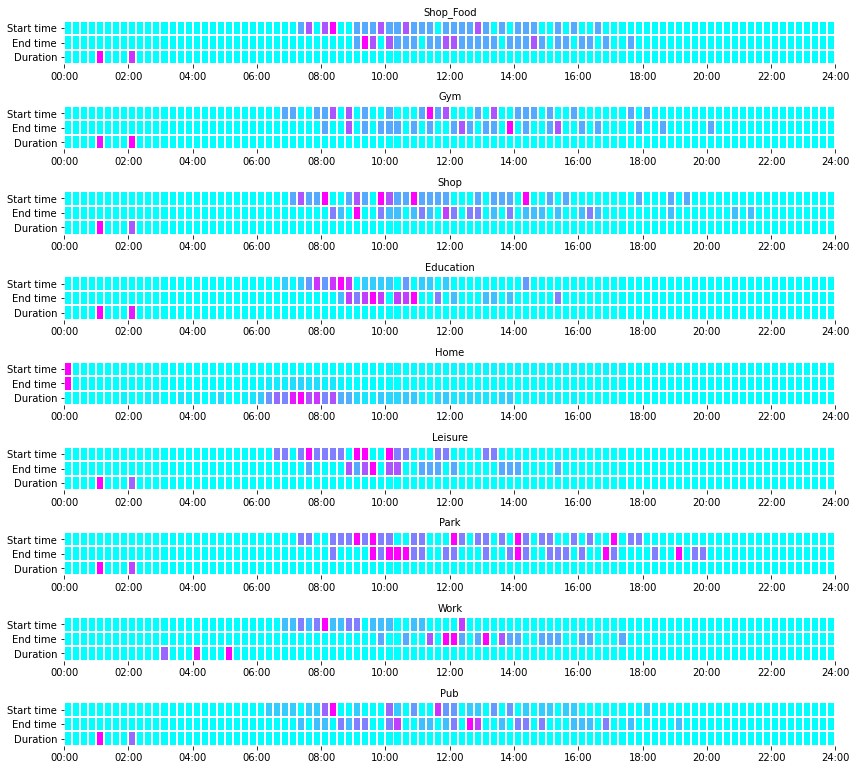

In [15]:
fig = plot_activity_times(population)

Plot the travel tours using different mode

In [16]:
mapbox_token = "pk.eyJ1IjoiZnJlZHNob25lIiwiYSI6ImNra3BvaWhlNTJuaDAyb3BnMmo0OXpybHQifQ.ztwILVrlwOZ5lWQs462j9w"

population.random_person().plot_travel_plotly(epsg='epsg:27700', mapbox_access_token=mapbox_token)

In [17]:
# Check the duration of trips
durations = write_duration_benchmark(population)
durations

duration  trips
0     0 to 5 min      0
1    5 to 10 min      7
2   10 to 15 min     21
3   15 to 30 min     76
4   30 to 45 min     65
5   45 to 60 min     69
6   60 to 90 min    113
7  90 to 120 min      0
8       120+ min      0

(-0.8400000000000001, 7.0)

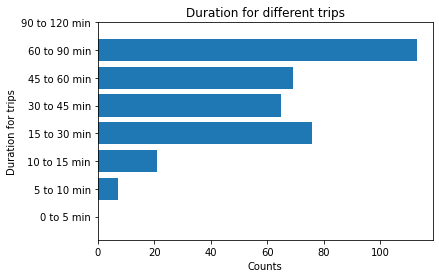

In [18]:
plt.barh(durations["duration"], durations["trips"])
plt.xlabel("Counts")
plt.ylabel("Duration for trips")
plt.title("Duration for different trips")
plt.ylim(ymax = "90 to 120 min")

In [19]:
# Check the distance of trips
distances  = write_distance_benchmark(population)
distances

distance  trips
0      0 to 1 km     27
1      1 to 5 km    241
2     5 to 10 km     83
3    10 to 25 km      0
4    25 to 50 km      0
5   50 to 100 km      0
6  100 to 200 km      0
7        200+ km      0

(-0.79, 4.0)

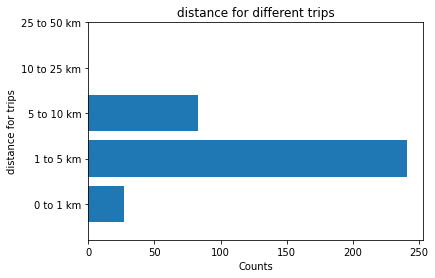

In [20]:
plt.barh(distances["distance"], distances["trips"])
plt.xlabel("Counts")
plt.ylabel("distance for trips")
plt.title("distance for different trips")
plt.ylim(ymax = "25 to 50 km")

## Export intermediate CSV tables of population

In [21]:
to_csv(population, dir = "outputs", crs = "epsg:27700")

Text(0.5, 1.0, 'activities count')

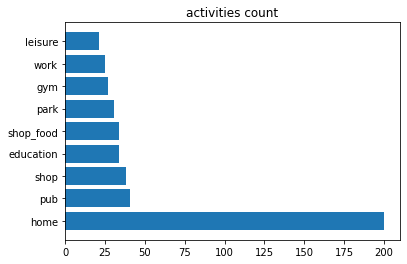

In [22]:
df_activity = pd.read_csv(os.path.join("outputs", "activities.csv"))
totals = df_activity.activity.value_counts()
plt.barh(totals.index, totals)
plt.title("activities count")

In [23]:
write_od_matrices(population, path = "outputs")
od_matrices = pd.read_csv(os.path.join("outputs", "total_od.csv"))  # we should change this method to be consistent with other - ie return a dataframe
od_matrices["total origins"] = od_matrices.drop("Origin", axis=1).sum(axis=1)
od_matrices

Origin  0  2  3  4  5  7  8  9  11  ...  292  295  297  298  299  300  \
0         0  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0   
1         2  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0   
2         3  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0   
3         4  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0   
4         5  0  0  0  0  0  0  0  0   0  ...    1    0    0    0    0    0   
..      ... .. .. .. .. .. .. .. ..  ..  ...  ...  ...  ...  ...  ...  ...   
203     299  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0   
204     300  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0   
205     302  0  0  0  0  0  0  0  1   0  ...    0    0    0    0    0    0   
206     303  0  0  0  0  0  0  0  1   0  ...    0    0    0    0    0    0   
207     305  0  0  0  0  0  0  0  0   0  ...    0    0    0    0    0    0   

     302  303  305  total origins  
0      0    0    0              2  
1      0    0    0              1  
2      0    0    0              4  
3      0    0    0              1  
4      0    0    0              1  
..   ...  ...  ...            ...  
203    0    0    0              2  
204    0    0    0              2  
205    0    0    0              3  
206    0    0    0              1  
207    0    0    0              2  

[208 rows x 210 columns]

Text(0.5, 1.0, 'Total Origins')

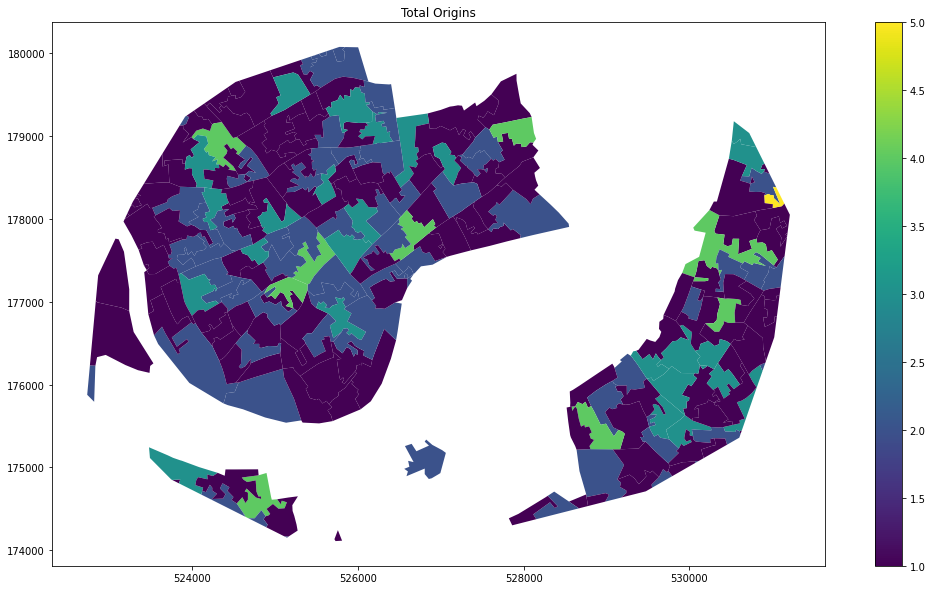

In [24]:
origins_heat_map = lsoas_clipped.join(od_matrices["total origins"])

fig, ax = plt.subplots(figsize=(18,10))    
origins_heat_map.plot("total origins", legend=True, ax=ax)
ax.set_title("Total Origins")

# Reload Load Tabular Data

We load in the csvs we previously wrote to disk. This replicates a simple synthesis process we might typically use for travel diary survey data.

In [25]:
people = pd.read_csv(os.path.join("outputs", "people.csv")).set_index('pid')
hhs = pd.read_csv(os.path.join("outputs", "households.csv")).set_index('hid')
trips = pd.read_csv(os.path.join("outputs", "legs.csv")).drop(['Unnamed: 0'],axis=1)

trips.rename(columns={'origin activity': 'oact', 'destination activity': 'dact'}, inplace=True)
trips.head()

pid   hid  freq  ozone  dzone  purp       oact       dact  mode  seq  \
0  agent_0  hh_0   NaN    213    241   NaN       home       work  walk    1   
1  agent_0  hh_0   NaN    241    171   NaN       work       shop  rail    2   
2  agent_0  hh_0   NaN    171    236   NaN       shop  shop_food  bike    3   
3  agent_0  hh_0   NaN    236    253   NaN  shop_food        pub   bus    4   
4  agent_0  hh_0   NaN    253    213   NaN        pub       home  bike    5   

                   tst                  tet duration  
0  1900-01-01 08:07:00  1900-01-01 08:37:00  0:30:00  
1  1900-01-01 13:37:00  1900-01-01 14:25:00  0:48:00  
2  1900-01-01 15:25:00  1900-01-01 16:34:00  1:09:00  
3  1900-01-01 17:34:00  1900-01-01 18:13:00  0:39:00  
4  1900-01-01 19:13:00  1900-01-01 20:24:00  1:11:00

In [26]:
population_reloaded = load_travel_diary(
    trips=trips,
    persons_attributes=people,
    hhs_attributes=hhs,
)

Using from-to activity parser using 'oact' and 'dact' columns


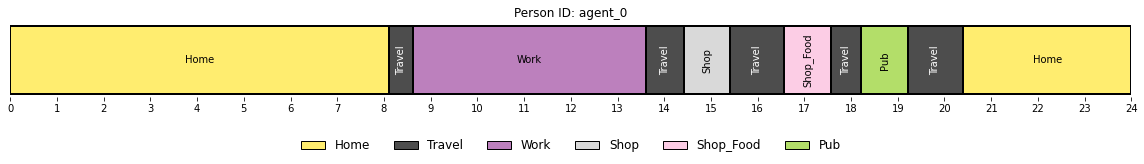

In [27]:
population["hh_0"]["agent_0"].plot()

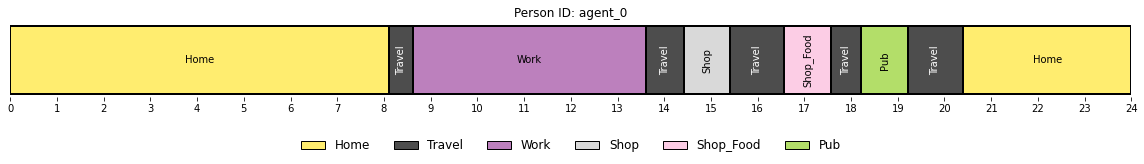

In [28]:
population_reloaded["hh_0"]["agent_0"].plot()

In [29]:
population == population_reloaded

False

the populations are not the same because the csvs did not preserve the coordinates that we previously sampled. So we will sample them again. But the reloaded population will be different as for each location a new coordinate is sampled.s

In [30]:
population_reloaded.sample_locs(point_sampler)

In [31]:
population_reloaded.random_person().plot_travel_plotly(epsg='epsg:27700', mapbox_access_token=mapbox_token)

# Finally lets write this to MATSim xml

In [32]:
write_matsim(population=population, plans_path=os.path.join("outputs", "population.xml"), version=12)

In [33]:
population_reloaded = read_matsim(
    plans_path=os.path.join("outputs", "population.xml"),
    household_key="hid",
    version=12
)

In [34]:
population_reloaded["hh_0"]["agent_0"].plot_travel_plotly(epsg='epsg:27700', mapbox_access_token=mapbox_token)

In [35]:
population["hh_0"]["agent_0"].plot_travel_plotly(epsg='epsg:27700', mapbox_access_token=mapbox_token)